# Introduction

Here, we apply the confidence set methods to one real fMRI dataset of 3D contrast maps from multiple people.  

**The Task**

In the experiment, 78 unrelated subjects performed two tasks spread across two runs where each run contained four blocks. During each block, the subject undertook either a 2-back memory task or a 0-back control task. The experimental design was arranged such that, in each run, two blocks were designated to the 2-back memory task, and two blocks were designated to the 0-back control task. In each block a subject was shown a stimuli image (a picture of a face or a place, for instance) and then asked to recall the image they were shown. They were either asked to recall the most recent image (the '0-back' image) or the image shown to them two images prior (the '2-back' image). Interest lies in assessing whether this delay impacted the \%BOLD response.


**First-level Analysis**

In FSL, a first-level analysis has been conducted independently for each subject. In each first-level analysis, the task design was regressed onto Blood Oxygenation Level Dependent (BOLD) response and a Contrast Parameter Estimate (COPE) map was generated. Each COPE map represents, for a given subject, the difference in BOLD response between the subject performing the 2-back task and the 0-back task (e.g $L\hat{\beta}=\hat{\beta}_{\text{2-Back}}-\hat{\beta}_{\text{0-Back}})$).


**Acquisition Details**

All image acquisitions were obtained using a $32$ channel head coil on a modified $3T$ Siemans Skyra scanner via a gradient-echo EPI sequence with TR $=720$ ms, TE $=33.1$ ms, $2.0$ mm slice thickness, $72$ slices, $2.0$ mm isotropic voxels, $208$ mm $\times 180$ mm FOV, and a multi-band acceleration factor of $8$.

 
For more information on these variables, please visit [this link](https://wiki.humanconnectome.org/display/PublicData/HCP-YA+Data+Dictionary-+Updated+for+the+1200+Subject+Release). Here is a brief view of the data.


In [ ]:
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt 
#import sanssouci as ss
import pyperm as pr
from nilearn.plotting import plot_img, plot_stat_map, view_img
from nilearn.image import get_data, load_img

# Data Import 

Now we read the data, which were previously downloaded into the folder. 


In [2]:
# Real data directory
import os
data_dir = os.path.join(os.getcwd(),'data')
real_data_dir = os.path.join(os.getcwd(),'data','hcp78')
# Only need to run if you already had the data downloaded:
data_loc = real_data_dir + '\\WM\\'
bold_files_total = os.listdir(data_loc)
bold_files = [os.path.join(data_loc, file) for file in bold_files_total]

In [3]:
print(len(bold_files))

78


First we apply the mask, which will reduce the image size and focus only on areas in the brain and apply some smoothing.

Here we proceed with the MNI mask.

the shape of the MNI mask: (91, 109, 91)
number of voxels inside the MNI mask 228483


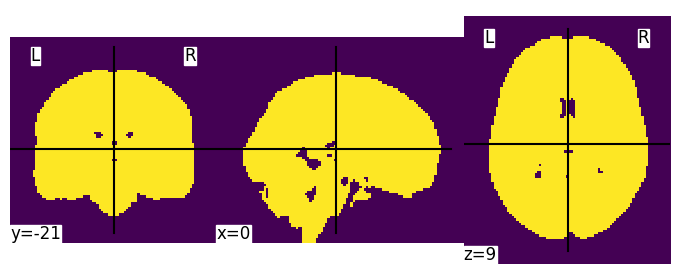

In [4]:
mask = data_dir + '\\MNImask.nii' #MNI mask 
plot_img(mask)
print("the shape of the MNI mask:", get_data(mask).shape)
print("number of voxels inside the MNI mask", np.sum(get_data(mask)))

In [5]:
from nilearn.input_data import NiftiMasker
fwhm = 5 # Set the smoothness parameter (in mm)

# this creates a NiftiMasker class, if mask_img is not prvided, will compute the mask in the fit step
masker = NiftiMasker(smoothing_fwhm=fwhm, mask_img=mask).fit()
# transform(imgs, counfounds=None, sample_mask=None): apply mask, spatial and temporal preprocessing. 
data = masker.transform(bold_files).transpose()
print(data.shape)

(228483, 78)


number of voxels in the mask: 902629 from shape: (91, 109, 91)
number of voxels being 1 in the mask: 228483
number of voxels in raw contrast image: 902629 from shape: (91, 109, 91)
number of voxels in unmasked data_mean_3d: 902629 from shape: (91, 109, 91)
number of voxels in masked data_mean: 228483


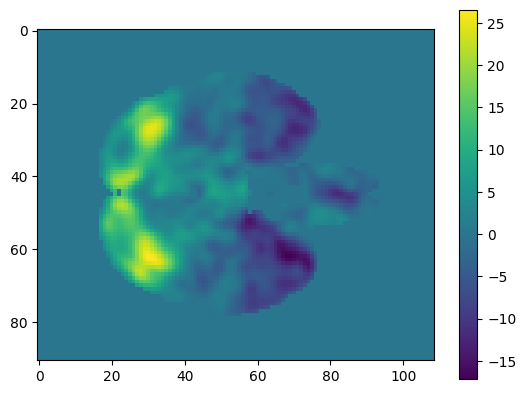

In [6]:
data_mean = np.mean(data, 1)

# masker.inverse_transform: Transform the 2D data matrix back to an image in brain space.
## This step only performs spatial unmasking, without inverting any additional processing performed by transform, such as temporal filtering or smoothing.
## using this unmasked version only for plotting. the analysis was done on maksed data. 
## get_data: Get the image data as a numpy.ndarray.
data_mean_3d = get_data(masker.inverse_transform(data_mean))


print("number of voxels in the mask:", np.prod(get_data(mask).shape), 'from shape:', get_data(mask).shape)
print("number of voxels being 1 in the mask:", np.sum(get_data(mask)))

# sanity check 
# raw 3D image has the largest shape
print("number of voxels in raw contrast image:", np.prod(get_data(bold_files[0]).shape), 'from shape:', get_data(bold_files[0]).shape)
# this is 3d unmasked(with inverse transform), so it has voxels outside the mask and has the same shape as the mask
print("number of voxels in unmasked data_mean_3d:", np.prod(data_mean_3d.shape), 'from shape:', data_mean_3d.shape)
# this is 1d masked data mean, so it only has voxels inside the mask
print("number of voxels in masked data_mean:", np.prod(data_mean.shape))
plt.imshow(data_mean_3d[:,:,23])
plt.colorbar()
plt.show()

# Confidence Set Construction

Now construct confidence sets by inverting the SCB from bootstrap. Based on the simulation results, we use t-bootstrap with rademacher multilpliers. This is done on the masked data of shape (228433*78). 

In [7]:
from SimuInf import scb, confset
from SimuInf.plotting import confset_plot, ls_plot
est, lower, upper, q = scb.confband(data, m_boots=1000, print_q=True, return_q=True)

0.05th upper quantile of the distribution of the maximum of the random field:5.110,computed from multiplier bootstrap with res, t standardization and r multiplier


In [8]:
# construct confidence sets based on a list of thresholds
threshold_ls = 1+np.arange(10)
set_masked_ls = [list(confset.confset(est, lower, upper, threshold=threshold)) for threshold in threshold_ls]
len(set_masked_ls)

10

In [9]:
# unmask to transform to 3d, this returns a list of Nifti1Imagec
set_unmasked_img_ls = [[masker.inverse_transform(set) for set in set_ls] for set_ls in set_masked_ls]
set_unmasked_ls = [[get_data(set) for set in img_ls] for img_ls in set_unmasked_img_ls]

In [10]:
print("number of activated voxels in masked 1d sets:", [np.sum(set) for set in set_masked_ls[0]])
print("number of activated voxels in unmasked 3d sets:", [np.sum(get_data(set)) for set in set_unmasked_img_ls[0]])

number of activated voxels in masked 1d sets: [99694, 20624, 206770]
number of activated voxels in unmasked 3d sets: [99694, 20624, 206770]


In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import Normalize

(91, 109, 91)


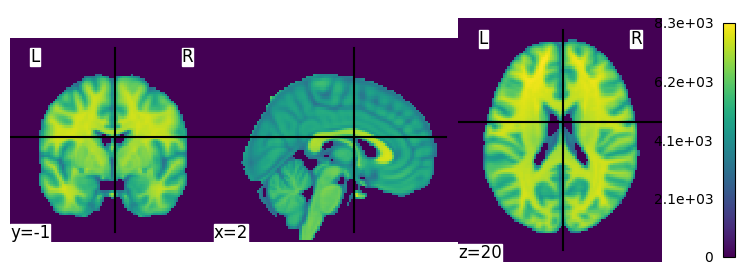

In [12]:
brain =  data_dir + '\\MNIbrain.nii.gz'
plot_img(brain, colorbar=True)
brain_array = get_data(brain)
print(brain_array.shape)

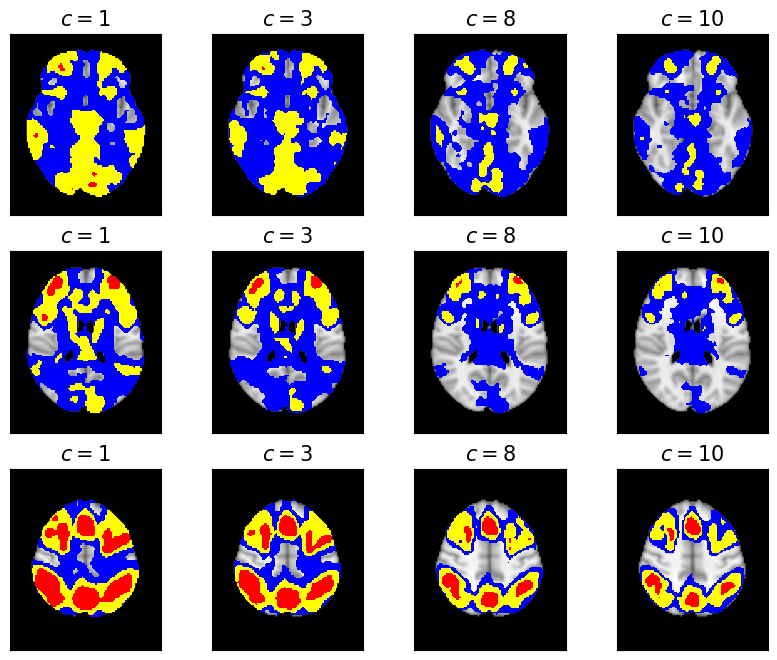

In [13]:
name_ls = [f'$c={i}$' for i in threshold_ls]
# for paper
set_unmasked_ls_selected = list(np.array(set_unmasked_ls)[[0,2,7,9]])
name_ls_selected = list(np.array(name_ls)[[0,2,7,9]])
confset_plot(set_unmasked_ls_selected, name_ls_selected, nrow=3, figsize=(10,8), fontsize=15, background =brain, cuts = [30,45,60], ticks=False)
#plt.savefig("fmri.jpg", dpi=600)

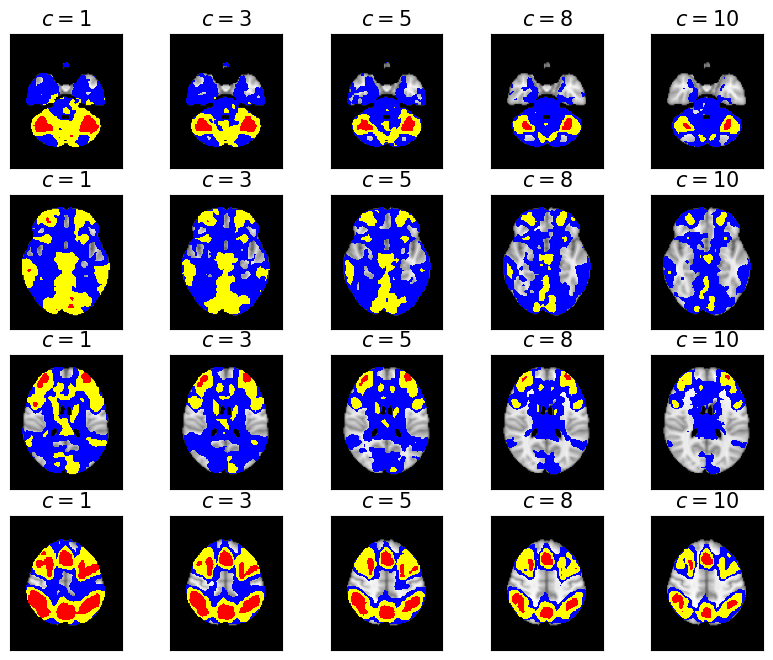

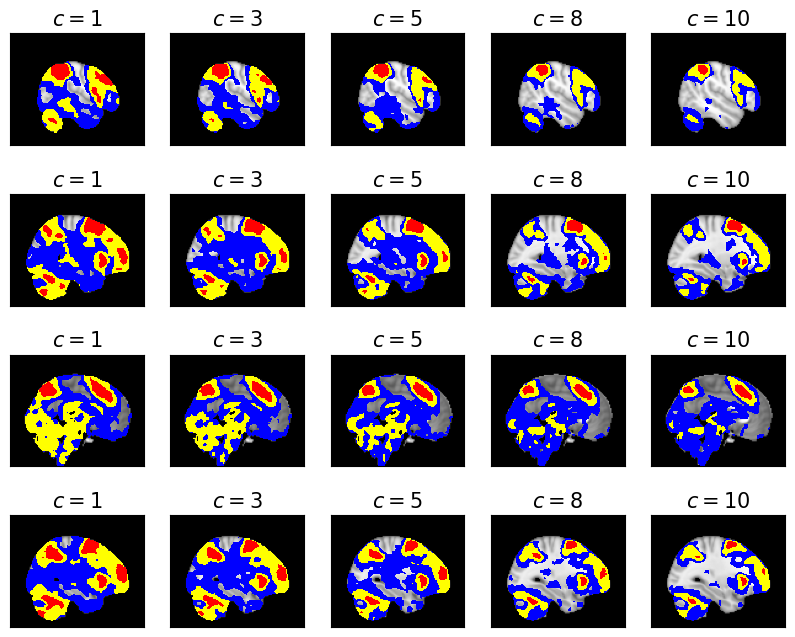

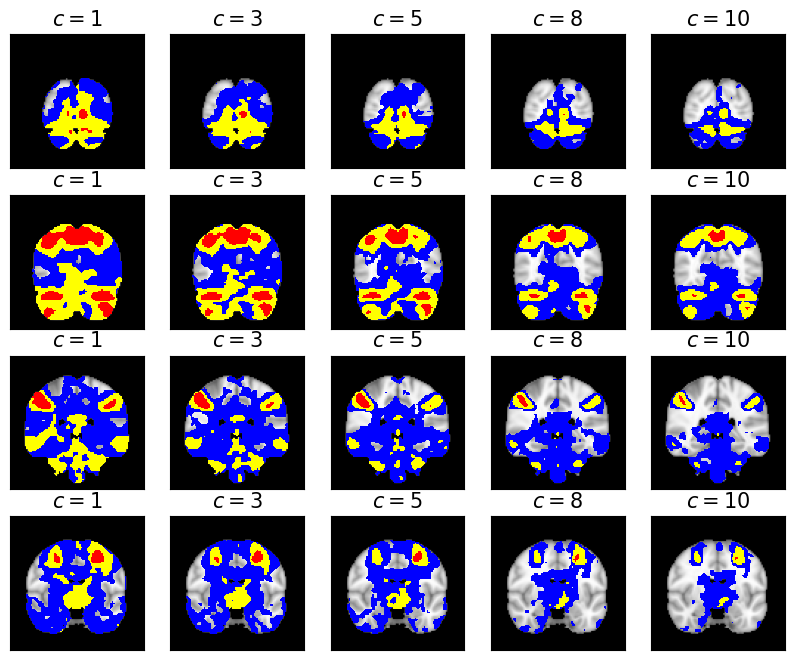

In [14]:
# for appendix
set_unmasked_ls_selected1 = list(np.array(set_unmasked_ls)[[0,2,4,7,9]])
name_ls_selected1 = list(np.array(name_ls)[[0,2,4, 7,9]])
confset_plot(set_unmasked_ls_selected1, name_ls_selected1, nrow=4, figsize=(10,8), fontsize=15, background =brain, cuts = [20, 30,45,60], ticks=False)
#plt.savefig("volume_hcp_z.jpg", dpi=600)
confset_plot(set_unmasked_ls_selected1, name_ls_selected1, nrow=4, figsize=(10,8), fontsize=15, background =brain, display_mode = 'x', cuts = [20, 30,45,60], ticks=False)
#plt.savefig("volume_hcp_x.jpg", dpi=600)
confset_plot(set_unmasked_ls_selected1, name_ls_selected1, nrow=4, figsize=(10,8), fontsize=15, background =brain, display_mode = 'y', cuts = [20, 30,45,60], ticks=False)
#plt.savefig("volume_hcp_y.jpg", dpi=600)